In [3]:
!pip install -q numpy torch
!pip install -q scikit-learn pandas shap
!pip install -q matplotlib seaborn

# Lab 1 Model definition and training

In [4]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Model definition

Use gpu if possible

In [5]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


### Define a model

In [6]:
import torch.nn as nn

class GenderClassifier(nn.Module):

    def __init__(self, input_size: int, hidden1_size: int, hidden2_size: int, output_size: int):
        super(GenderClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.fc3 = nn.Linear(hidden2_size, output_size)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))

        return x


### Load and prepare dataset

In [7]:
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML/data/hr_data_gold.csv")

label = 'Gender_Male'
features = [c for c in df.columns if c != label]

# create tensors
X = torch.tensor(df[features].values, dtype=torch.float32).to(device)
y = torch.tensor(df[label].values, dtype=torch.long).to(device)

# create tensor dataframe
ds = TensorDataset(X, y)

# split data
train_size = int(0.8 * len(ds))
test_size = len(ds) - train_size
ds_train, ds_test = random_split(ds, [train_size, test_size])

# create loaders
all_loader  = DataLoader(ds, batch_size=1, shuffle=False)
train_loader = DataLoader(ds_train, batch_size=32, shuffle=True)
test_loader = DataLoader(ds_test, batch_size=1, shuffle=True)

### Learn model 96 x 48

In [8]:
# check backup
try:
  model = torch.load("/content/drive/MyDrive/Colab Notebooks/ML/models/model_96_48_b32_e300.pt")
except Exception:
  print("No backup found")
  model = None

No backup found


In [9]:
import torch.optim as optim
from sklearn.metrics import accuracy_score
import sys

if model == None:
  model = GenderClassifier(len(features), 96, 48, 2).to(device)

  train_accuracy_log = []
  test_accuracy_log = []

  optimizer = optim.Adam(model.parameters(), lr=0.001)
  criterion = nn.CrossEntropyLoss()
  epochs = 300

  for epoch in range(epochs):
      # train
      model.train()
      for X_batch, y_batch in train_loader:
          optimizer.zero_grad()
          output = model(X_batch)
          loss = criterion(output, y_batch)
          loss.backward()
          optimizer.step()

      # calculate train_ds and test_ds accuracy
      with torch.no_grad():
          model.eval()
          train_features, train_labels = ds_train[:][0], ds_train[:][1]
          # Process all features at once
          train_pred = model(train_features).argmax(dim=1)
          train_accuracy = accuracy_score(train_labels.cpu(), train_pred.cpu())
          train_accuracy_log.append(train_accuracy)

          test_features, test_labels = ds_test[:][0], ds_test[:][1]
          # Process all features at once
          test_pred = model(test_features).argmax(dim=1)
          test_accuracy = accuracy_score(test_labels.cpu(), test_pred.cpu())
          test_accuracy_log.append(test_accuracy)


      if epoch % 5 == 0:
        print(f"Progress: {epoch / epochs * 100:.1f} %")

Progress: 0.0 %
Progress: 1.7 %
Progress: 3.3 %
Progress: 5.0 %
Progress: 6.7 %
Progress: 8.3 %
Progress: 10.0 %
Progress: 11.7 %
Progress: 13.3 %
Progress: 15.0 %
Progress: 16.7 %
Progress: 18.3 %
Progress: 20.0 %
Progress: 21.7 %
Progress: 23.3 %
Progress: 25.0 %
Progress: 26.7 %
Progress: 28.3 %
Progress: 30.0 %
Progress: 31.7 %
Progress: 33.3 %
Progress: 35.0 %
Progress: 36.7 %
Progress: 38.3 %
Progress: 40.0 %
Progress: 41.7 %
Progress: 43.3 %
Progress: 45.0 %
Progress: 46.7 %
Progress: 48.3 %
Progress: 50.0 %
Progress: 51.7 %
Progress: 53.3 %
Progress: 55.0 %
Progress: 56.7 %
Progress: 58.3 %
Progress: 60.0 %
Progress: 61.7 %
Progress: 63.3 %
Progress: 65.0 %
Progress: 66.7 %
Progress: 68.3 %
Progress: 70.0 %
Progress: 71.7 %
Progress: 73.3 %
Progress: 75.0 %
Progress: 76.7 %
Progress: 78.3 %
Progress: 80.0 %
Progress: 81.7 %
Progress: 83.3 %
Progress: 85.0 %
Progress: 86.7 %
Progress: 88.3 %
Progress: 90.0 %
Progress: 91.7 %
Progress: 93.3 %
Progress: 95.0 %
Progress: 96.7 %
Pro

### Save the model

In [10]:
torch.save(model, "/content/model_96_48_b32_e300.pt")

# Lab 2 - Model evaluation and optimization

In [11]:
model = torch.load("/content/model_96_48_b32_e300.pt", weights_only=False)

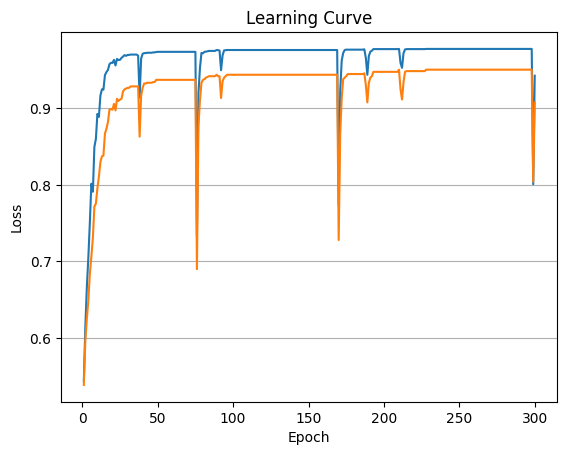

In [12]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
x = list(range(1, epochs + 1))

plt.plot(x, train_accuracy_log, label="Train accuracy")
plt.plot(x, test_accuracy_log, label="Test accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.grid(axis = 'y')
plt.show()

### Validation
- Accuracy
- Precusion
- Recall
- Confusion Matrix
- ROC

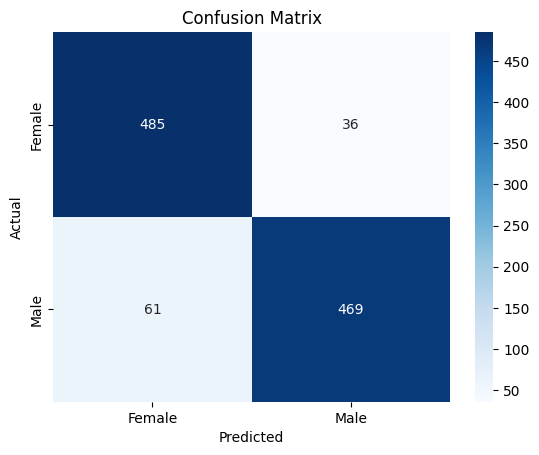

Accuracy:  0.9077
Precision: 0.9287
Recall:    0.8849
F1 Score:  0.9063


In [13]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

model.eval()

all_preds = []
all_labels = []
all_results = []

with torch.no_grad():
    for X, y in test_loader:
        outputs = model.cpu()(X.cpu())
        all_results.append(outputs[0])
        preds = torch.argmax(outputs, dim=1)
        all_labels.append(y.cpu())
        all_preds.append(preds)

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)



sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Female", "Male"], yticklabels=["Female", "Male"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


### ROC curve

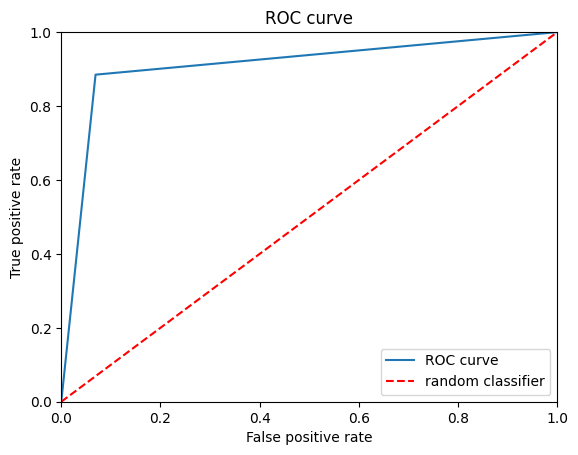

In [14]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
auc_score = auc(fpr, tpr)

# plot ROC
plt.plot(fpr, tpr, label="ROC curve")
plt.plot([0,1], [0,1], color="red", linestyle="--",label="random classifier")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.show()

**Observation: For one model there is a ROC point not ROC curve**

### Predefined models benchmark

In [15]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML/data/hr_data_gold.csv")
feature_names = [c for c in df.columns if c != "Gender_Male"]
label_name = "Gender_Male"
X_train, X_test, y_train, y_test = train_test_split(df[feature_names], df[label_name], test_size = 0.2, random_state=42)

models = {
    "SVC": SVC(probability=True),
    "RandomForestClassifier": RandomForestClassifier(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "LogisticRegression": LogisticRegression(),
    "GaussianNB": GaussianNB(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}
results = {}

for name, m in models.items():
  m.fit(X_train, y_train)
  y_pred = m.predict(X_test)
  results[name] = {"accuracy_score": accuracy_score(y_test, y_pred)}
  print(f"{name} model accuracy: {results[name]['accuracy_score']}")


SVC model accuracy: 0.7735490009514748
RandomForestClassifier model accuracy: 0.9952426260704091
KNeighborsClassifier model accuracy: 0.7440532825880114
LogisticRegression model accuracy: 0.5518553758325404
GaussianNB model accuracy: 0.5252140818268316
DecisionTreeClassifier model accuracy: 0.9895337773549001


**RandomForestClassifier has over 99% accuracy tested on never-seen data. It would be awesome to see how the model works on data from other companies or countries and it it remains high**

### Hiperparameters configuration

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def estimate_model_accuracy(models_count: int, **kwargs) -> float:
  basic_models = {f"RandomForest_{i}" : RandomForestClassifier(**kwargs) for i in range(models_count) }
  accuracies = []

  for n, m in basic_models.items():
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f"Model {n}: {accuracy:.4f}")

  mean_accuracy = sum(accuracies) / len(accuracies)
  return mean_accuracy

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# lets take Random Forest model
# lern 5 models with basic configuration and take mean as reference
mean_accuracy = estimate_model_accuracy(5)
print(f"{30*'='}\nMean accuracy: {mean_accuracy:.4f}")

Model RandomForest_0: 0.9952
Model RandomForest_1: 0.9981
Model RandomForest_2: 0.9971
Model RandomForest_3: 0.9952
Model RandomForest_4: 0.9971
Mean accuracy: 0.9966


Now lest's try to search better configuration with Random Search

In [18]:
import random
hiperparameters_ranges = {"n_estimators": list(range(1, 500)), "max_depth": list(range(1, len(df.columns))), "min_samples_split": list(range(2, 10)), "max_features": ['sqrt', 'log2']}
best_config = {}
best_model = None
best_accuracy = 0

for gen in range(generations:=100):
  if gen % 10 == 0:
    print(f"Generation {gen}")
  kwargs = {k: random.choice(v) for k, v in hiperparameters_ranges.items()}
  model = RandomForestClassifier(**kwargs)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)

  if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_config = kwargs
    best_model = model

print(f"{30*'='}\nBest accuracy: {best_accuracy:.4f}")



Generation 0
Generation 10
Generation 20
Generation 30
Generation 40
Generation 50
Generation 60
Generation 70
Generation 80
Generation 90
Best accuracy: 0.9981


### Random forest default config vs quazi-optimal

In [19]:
# get random forest classifier defaul config
print(f"Optimized config: {best_config}")
print(f"Optimized accuracy: {best_accuracy}")
print(f"Default config: {RandomForestClassifier().get_params()}")
print(f"Default accuracy: {mean_accuracy}")

Optimized config: {'n_estimators': 320, 'max_depth': 26, 'min_samples_split': 5, 'max_features': 'log2'}
Optimized accuracy: 0.9980970504281637
Default config: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Default accuracy: 0.9965746907706945


### Feature importance analysis wit SHAP

In [20]:
import shap
medianes = X_train.median().values.reshape((1, X_train.shape[1]))

f = lambda x: best_model.predict(x);
explainer = shap.Explainer(f, medianes, feature_names=features)
shap_values  = explainer(X_test.iloc[0:1000, :]) # for 1000 records

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestCla

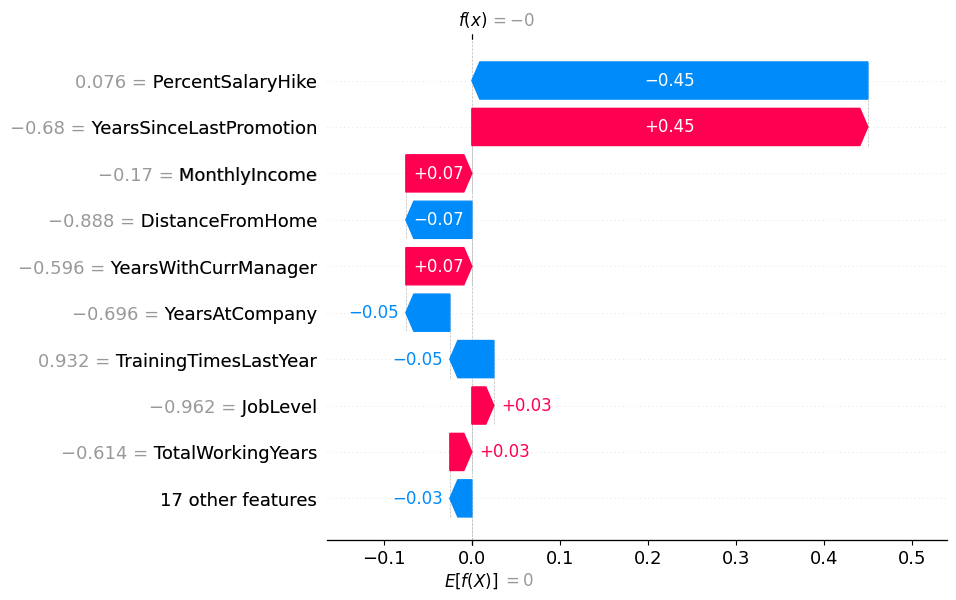

In [21]:
shap.plots.waterfall(shap_values[0]) # features importance for record with idx 0

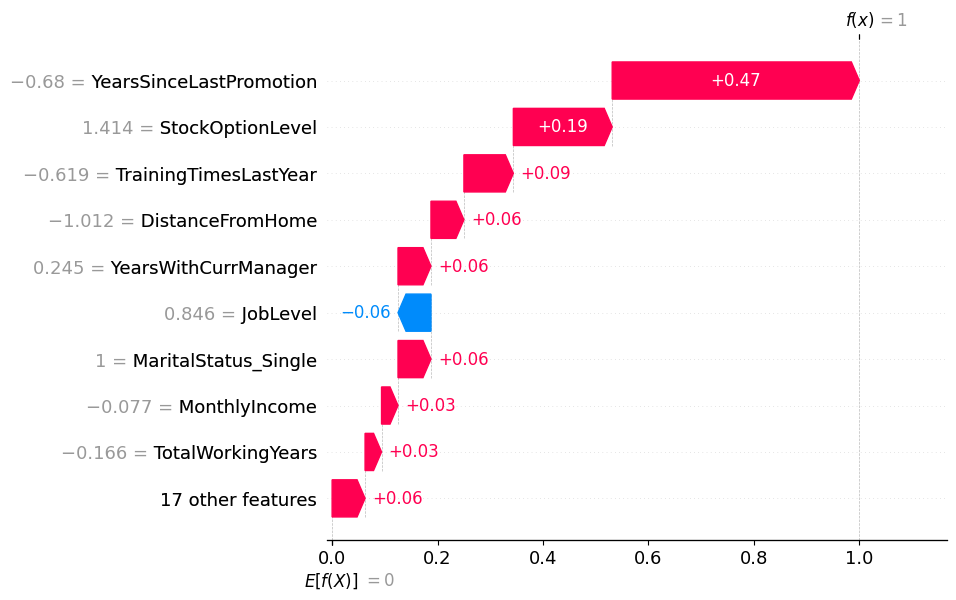

In [22]:
shap.plots.waterfall(shap_values[1]) # features importance for record with idx 1

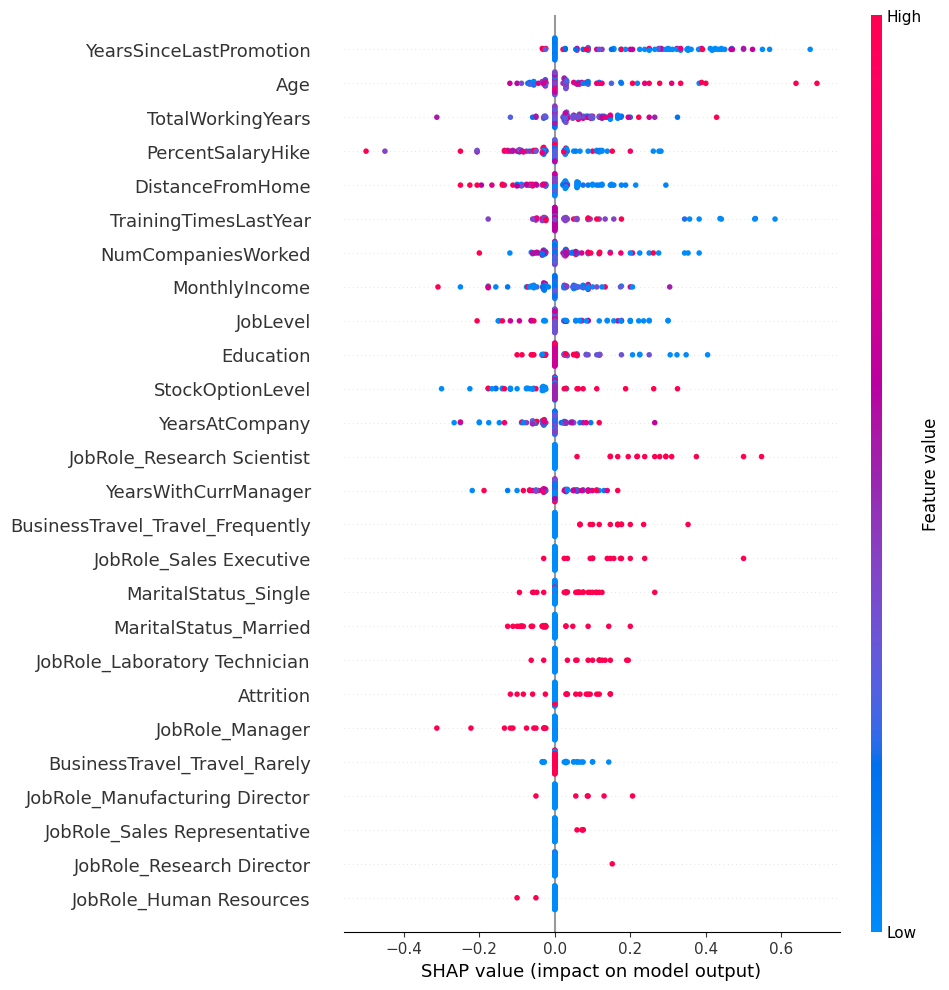

In [23]:
shap.plots.beeswarm(shap_values[:100], max_display=len(features))

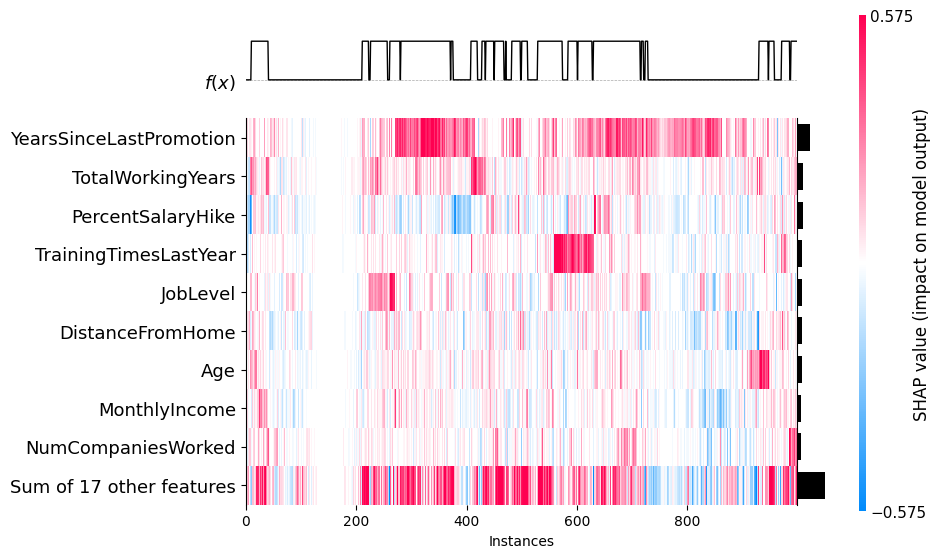

<Axes: xlabel='Instances'>

In [24]:
shap.plots.heatmap(shap_values)

In [25]:
# Looks like YearsSinceLastPromotion has a significant impact on the classification
# let's check what is a distribution of that feature for Males and Females
# for that we need silver data, without normalizatione
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML/data/hr_data_silver.csv")

1756


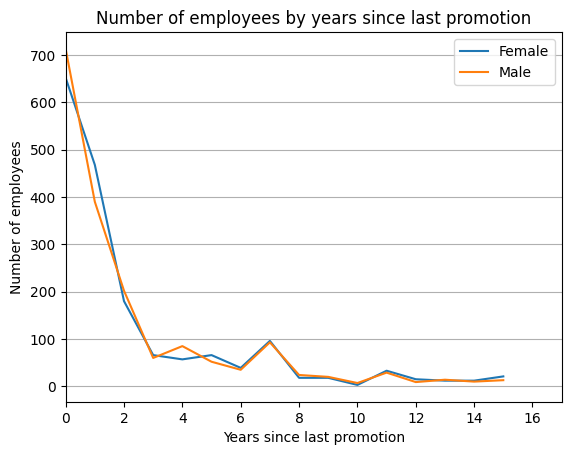

In [26]:
limit = min(len(df[df['Gender'] == "Male"]), len(df[df['Gender'] == "Female"]))
print(limit)
female_promotions = df[df['Gender'] == "Female"].sample(limit).groupby("YearsSinceLastPromotion").count()["Gender"]
male_promotions = df[df['Gender'] == "Male"].sample(limit).groupby("YearsSinceLastPromotion").count()["Gender"]

x = list(range(0, 16))
plt.plot(x, female_promotions, label="Female")
plt.plot(x, male_promotions, label="Male")
plt.xlabel("Years since last promotion")
plt.ylabel("Number of employees")
plt.title("Number of employees by years since last promotion")
plt.xlim(0, 17)
plt.grid(axis = 'y')
plt.legend()
plt.show()